# **Automatic car detection using MASK-RCNN**
### DOMAIN: Automotive. Surveillance.
### CONTEXT:
Computer vision can be used to automate supervision and generate action appropriate action trigger if the event is
predicted from the image of interest. For example a car moving on the road can be easily identified by a camera as make of
the car, type, colour, number plates etc.
### DATA DESCRIPTION:
The Cars dataset contains 16,185 images of 196 classes of cars. The data is split into 8,144 training images and 8,041 testing
images, where each class has been split roughly in a 50-50 split. Classes are typically at the level of Make, Model, Year, e.g.
2012 Tesla Model S or 2012 BMW M3 coupe.
Data description:
‣ Train Images: Consists of real images of cars as per the make and year of the car.
‣ Test Images: Consists of real images of cars as per the make and year of the car.
‣ Train Annotation: Consists of bounding box region for training images.
‣ Test Annotation: Consists of bounding box region for testing images.

In [1]:
## During this project there were lot of issues faced with respect to the version of Tensor flow and keras as matterport Mask-RCNN has compatibility issues.
## Below versions are installed to get rid of the issues faced through out the project
# faced ImportError: cannot import name 'get_submodules_from_kwargs' from 'keras_applications' (/usr/local/lib/python3.7/dist-packages/keras_applications/__init__.py)
#Hence tryign these versions
# making tensorflow==1.15 and keras==2.3.0 to resolve mrcnn import issue 
#AttributeError: module 'keras.engine' has no attribute 'Layer'
#!pip install 'keras==2.2.5' --force-reinstall
#to resolve eblow issue downgarding keras to 2.2.5 pip install 'keras==2.2.5' --force-reinstall
#AttributeError: 'Model' object has no attribute 'metrics_tensors'
#Downgrading h5py to resolve AttributeError: 'str' object has no attribute 'decode'
#!pip install 'h5py==2.10.0' --force-reinstall
#!pip install -U scikit-image==0.16.2
#done Above step or warning in training : Input image dtype is bool. Interpolation is not defined with bool data type.
!pip install tensorflow==1.15
!pip install keras==2.2.1
!pip install keras-applications==1.0.7
!pip install 'h5py==2.10.0' --force-reinstall
!pip install -U scikit-image==0.16.2


     |████████████████████████████████| 412.3 MB 26 kB/s 
     |████████████████████████████████| 50 kB 8.8 MB/s 
     |████████████████████████████████| 503 kB 63.2 MB/s 
     |████████████████████████████████| 3.8 MB 47.3 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=005674336f76aebe7a18a0023ef3814b9a330ddd939cef66dc59adab6da69bc3
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Succes

     |████████████████████████████████| 26.5 MB 2.3 MB/s 
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.18.3
    Uninstalling scikit-image-0.18.3:
      Successfully uninstalled scikit-image-0.18.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
## gettign the mask-RCNN packages
!git clone https://github.com/matterport/Mask_RCNN.git
!cd Mask_RCNN && python setup.py install


Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 125.23 MiB | 24.33 MiB/s, done.
Resolving deltas: 100% (565/565), done.
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'license-file' will not be supported in future versions. Please use the underscore name 'license_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'requirements-file' will not be supported in future versions. Please use the underscore name 'requirements_file' instead
  % (opt, underscore_opt))
running install
running bdis

In [3]:
import os,sys
ROOT_DIR = os.path.abspath("./Mask_RCNN")
sys.path.append(ROOT_DIR) 

In [4]:
import tensorflow as tf
import keras 
print(tf.__version__)
from mrcnn.utils import Dataset,extract_bboxes
from mrcnn.visualize import display_instances
from mrcnn.config import Config
from mrcnn.utils import compute_ap,compute_recall,compute_iou,compute_matches
from mrcnn.model import MaskRCNN
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image

Using TensorFlow backend.


1.15.0


In [5]:
import pandas as pd
import numpy as np
import os,sys
from os import listdir
from numpy import zeros, asarray, expand_dims, mean
from matplotlib import pyplot

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
project_path = '/content/drive/MyDrive/AIML/Capstone/Dataset/'

## **Import Data into Dataframes**

In [8]:
#Different car labels
car_names = pd.read_csv( project_path+'Car names and make.csv', header=None, names = ['CarLabel'] )

#Train data
train_data = pd.read_csv( project_path+'Annotations/Train Annotations.csv', skiprows=1, names = ['Image Name', 'X1', 'Y1', 'X2' , 'Y2', 'Class'] )

#Test data
test_data = pd.read_csv( project_path+'Annotations/Test Annotation.csv' , skiprows=1, names = ['Image Name', 'X1', 'Y1', 'X2' , 'Y2', 'Class'])

#Display few sample records
print (car_names.head() )
print ( )
print (train_data.head() )
print ( )
print (test_data.head() )


                     CarLabel
0  AM General Hummer SUV 2000
1         Acura RL Sedan 2012
2         Acura TL Sedan 2012
3        Acura TL Type-S 2008
4        Acura TSX Sedan 2012

  Image Name   X1   Y1    X2    Y2  Class
0  00001.jpg   39  116   569   375     14
1  00002.jpg   36  116   868   587      3
2  00003.jpg   85  109   601   381     91
3  00004.jpg  621  393  1484  1096    134
4  00005.jpg   14   36   133    99    106

  Image Name   X1   Y1   X2   Y2  Class
0  00001.jpg   30   52  246  147    181
1  00002.jpg  100   19  576  203    103
2  00003.jpg   51  105  968  659    145
3  00004.jpg   67   84  581  407    187
4  00005.jpg  140  151  593  339    185


In [9]:
all_folders_train= os.listdir(project_path+'Car Images/Train Images')
all_folders_test= os.listdir(project_path+'Car Images/Test Images')

In [11]:
 distiList_train=[]
 labelList_train=[]
 for i in all_folders_train:
  if not i.startswith('.') :
    eachFolder=os.listdir(project_path+'Car Images/Train Images/'+i)
    distiList_train.append(len(eachFolder))
    labelList_train.append(i)


In [22]:
print('Number of Images in each category of car in train list')
print(distiList_train)
print('Minimum number of elements in any folder')
print(min(distiList_train))
print('Maximum number of elements in any folder')
print(max(distiList_train))

Number of Images in each category of car in train list
[42, 43, 32, 39, 45, 41, 33, 45, 41, 45, 43, 38, 37, 43, 41, 41, 45, 40, 43, 42, 40, 46, 43, 39, 44, 41, 46, 37, 45, 35, 36, 41, 43, 36, 42, 44, 41, 34, 41, 45, 39, 44, 42, 42, 41, 33, 35, 38, 43, 42, 45, 41, 43, 45, 40, 38, 45, 42, 30, 47, 37, 35, 45, 45, 39, 43, 43, 44, 44, 40, 49, 44, 37, 44, 40, 38, 43, 41, 45, 44, 42, 45, 41, 38, 39, 42, 39, 41, 41, 44, 44, 44, 40, 46, 43, 44, 40, 46, 40, 43, 39, 28, 42, 34, 38, 44, 43, 45, 43, 45, 43, 45, 44, 42, 45, 40, 42, 45, 46, 45, 42, 39, 68, 43, 24, 42, 39, 39, 44, 41, 42, 44, 42, 43, 42, 44, 40, 41, 42, 34, 34, 35, 40, 47, 44, 44, 45, 51, 46, 43, 52, 37, 43, 36, 44, 36, 29, 44, 45, 48, 44, 37, 46, 45, 46, 42, 50, 41, 44, 37, 46, 39, 44, 41, 39, 42, 31, 44, 45, 43, 40, 46, 42, 38, 41, 39, 44, 41, 49, 44, 39, 43, 43, 46, 43, 42]
Minimum number of elements in any folder
24
Maximum number of elements in any folder
68


### Find class name with '/' and replace with -

In [13]:
for i in range(len(car_names)) :
  if '/' in car_names.loc[i,"CarLabel"]:
    print(car_names.loc[i,"CarLabel"])
    print(i)

Ram C/V Cargo Van Minivan 2012
173


In [14]:
#Replace '/' with '-' in the name
car_names.loc[173,'CarLabel'] = 'Ram C-V Cargo Van Minivan 2012'

## Map training images to corresponding classes and annotations

In [15]:
car_names['Class'] = car_names.index + 1
car_train_df = pd.merge(train_data, car_names, how = 'left', left_on='Class', right_on='Class' )
car_train_df.head() 

Image Name   X1   Y1    X2    Y2  Class                             CarLabel
0  00001.jpg   39  116   569   375     14                  Audi TTS Coupe 2012
1  00002.jpg   36  116   868   587      3                  Acura TL Sedan 2012
2  00003.jpg   85  109   601   381     91           Dodge Dakota Club Cab 2007
3  00004.jpg  621  393  1484  1096    134     Hyundai Sonata Hybrid Sedan 2012
4  00005.jpg   14   36   133    99    106  Ford F-450 Super Duty Crew Cab 2012

 ## Map Test images to corresponding classes and annotations

In [17]:
car_test_df = pd.merge(test_data, car_names, how = 'left', left_on='Class', right_on='Class' )
car_test_df.head()

Image Name   X1   Y1   X2   Y2  Class                             CarLabel
0  00001.jpg   30   52  246  147    181              Suzuki Aerio Sedan 2007
1  00002.jpg  100   19  576  203    103  Ferrari 458 Italia Convertible 2012
2  00003.jpg   51  105  968  659    145                Jeep Patriot SUV 2012
3  00004.jpg   67   84  581  407    187              Toyota Camry Sedan 2012
4  00005.jpg  140  151  593  339    185             Tesla Model S Sedan 2012

## Let us visualize the distribution of Test data

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


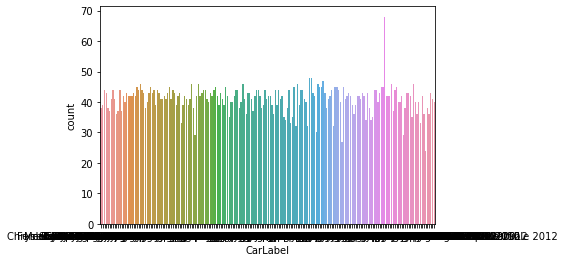

In [18]:
import seaborn as sns
sns.countplot(car_test_df['CarLabel'])

## Let us visualize the distribution of Train Data 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


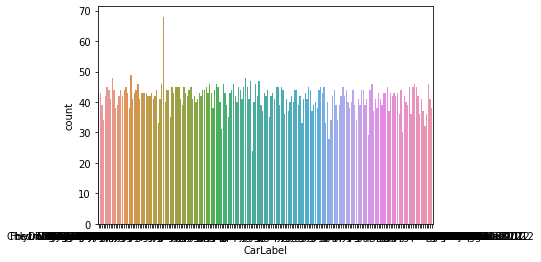

In [19]:
sns.countplot(car_train_df['CarLabel'])

## Dsitribution is almost similar with one outlier in train and one in test.

##  **Let us create the Dataset needed for Mask-RCNN to work**

In [23]:
class CarsDataset(Dataset):
    '''
    Dataset class to load the images and their bounding boxes in the form of masks
    '''
    def load_dataset(self, dataset_dir=project_path+'Car Images', mode='train'):
        '''
        This function is used to load the dataset. 
        We also have test set for which we dont have labels but are useful for visually checking 
        for how effective the training was
        '''
        self.add_class('dataset',1,'car')
        if mode=='train':
            images_dir = dataset_dir + '/Train Images/'
            eachFolder_train = []
            for i in all_folders_train:
              if not i.startswith('.') :
                eachFolder_train=os.listdir(images_dir+i)
              for eachFile_id in eachFolder_train:
                if not eachFile_id.startswith('.') :
                  img_path = images_dir+i+'/' + eachFile_id
                  image_id = eachFile_id
                  print('TrainImage is : '+img_path)
                  self.add_image('dataset', image_id=image_id, path=img_path)
            #for i in range(500):
             #   image_id = bb_df.iloc[i,0]
              #  img_path = images_dir + image_id
               # self.add_image('dataset', image_id=image_id, path=img_path)
        '''if mode=='val':
            images_dir = dataset_dir + '/Train Images/'
            for i in range(200,len(bb_df)):
                image_id = bb_df.iloc[i,0]
                img_path = images_dir + image_id
                self.add_image('dataset', image_id=image_id, path=img_path)'''
        if mode=='test':
            images_dir = dataset_dir + '/Test Images/'
            eachFolder_test =[]
            for i in all_folders_test:
              if not i.startswith('.') :
                eachFolder_test=os.listdir(images_dir+i)
                countTest=0
              for eachFile_id in eachFolder_test:
                # Taking only 20 images from each folder to be part of test set
                if not eachFile_id.startswith('.') and countTest <20:
                  img_path = images_dir+i+'/' + eachFile_id
                  image_id = eachFile_id
                  self.add_image('dataset', image_id=image_id, path=img_path)
                  print('TestImage: is : '+img_path)
                  countTest = countTest+1
                ''' for filename in listdir(images_dir):
                image_id = filename
                img_path = images_dir + filename
                self.add_image('dataset', image_id=image_id, path=img_path)'''
        
    def extract_boxes(self, filename):
        '''
        To get the coordinates of the bounding boxes.
        '''
        boxes = list()
        xmin = int(train_data[train_data['Image Name']==filename].iloc[0,1])
        ymin = int(train_data[train_data['Image Name']==filename].iloc[0,2])
        xmax = int(train_data[train_data['Image Name']==filename].iloc[0,3])
        ymax = int(train_data[train_data['Image Name']==filename].iloc[0,4])
        coors = [xmin, ymin, xmax, ymax]
        boxes.append(coors)
        width = 380
        height = 676
        return boxes, width, height
    def load_mask(self, image_id):
        '''
        Takes the co-ordinates and uses that to make it into a mask.
        '''
        info = self.image_info[image_id]
        file = info['id']
        boxes, w, h = self.extract_boxes(file)
        masks = zeros([w, h, len(boxes)], dtype='uint8')
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('car'))
        return masks, asarray(class_ids, dtype='int32')
    
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

## Making test and train set to do initiate the model training

In [24]:
train_set = CarsDataset()
train_set.load_dataset(mode='train')
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

val_set = CarsDataset()
val_set.load_dataset(mode='val')
val_set.prepare()
print('Validate: %d' % len(val_set.image_ids))
 
test_set = CarsDataset()
test_set.load_dataset(mode='test')
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Streaming output truncated to the last 5000 lines.
TrainImage is : /content/drive/MyDrive/AIML/Capstone/Dataset/Car Images/Train Images/Porsche Panamera Sedan 2012/05680.jpg
TrainImage is : /content/drive/MyDrive/AIML/Capstone/Dataset/Car Images/Train Images/Porsche Panamera Sedan 2012/04173.jpg
TrainImage is : /content/drive/MyDrive/AIML/Capstone/Dataset/Car Images/Train Images/Porsche Panamera Sedan 2012/06281.jpg
TrainImage is : /content/drive/MyDrive/AIML/Capstone/Dataset/Car Images/Train Images/Porsche Panamera Sedan 2012/05907.jpg
TrainImage is : /content/drive/MyDrive/AIML/Capstone/Dataset/Car Images/Train Images/Porsche Panamera Sedan 2012/04811.jpg
TrainImage is : /content/drive/MyDrive/AIML/Capstone/Dataset/Car Images/Train Images/Porsche Panamera Sedan 2012/03462.jpg
TrainImage is : /content/drive/MyDrive/AIML/Capstone/Dataset/Car Images/Train Images/Porsche Panamera Sedan 2012/01662.jpg
TrainImage is : /content/drive/MyDrive/AIML/Capstone/Dataset/Car Images/Train Images/Por

## Plotting random images from the train set

In [25]:
def plot(num_img=5):
    for i in range(num_img):
        image_id = np.random.randint(0,len(train_set.image_ids))
        image = train_set.load_image(image_id)
        print(image.shape)
        mask, class_ids = train_set.load_mask(image_id)
        print(mask.shape)
        pyplot.imshow(image)
        pyplot.imshow(mask[:, :, 0], cmap='gray', alpha=0.3)
        pyplot.show()

(152, 332, 3)
(380, 676, 1)


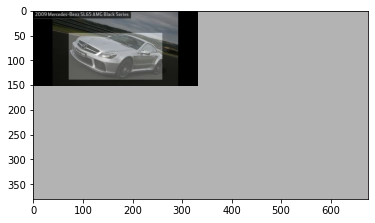

(1067, 1600, 3)
(380, 676, 1)


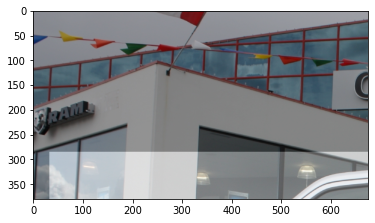

(434, 620, 3)
(380, 676, 1)


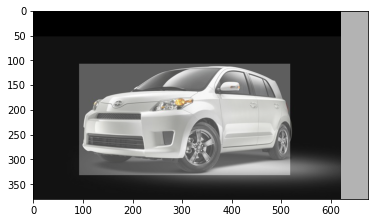

(683, 1024, 3)
(380, 676, 1)


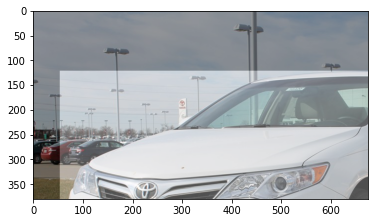

(492, 786, 3)
(380, 676, 1)


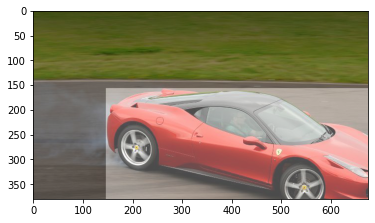

In [26]:
plot()

## Config in mask-rcnn corresponding to the pre-processign specifications the model requires.
## Defining Training config

In [27]:
class CarsConfig(Config):
    NAME = "cars_cfg"
    NUM_CLASSES = 2 #Background is counted as class too so background + cars = 2 labels
    STEPS_PER_EPOCH = 70
    VALIDATION_STEPS = 20
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = 384
    #256
    IMAGE_MAX_DIM = 448
    #256
    
config = CarsConfig()

In [28]:
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  448
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  384
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [448 448   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

## Defining model

In [29]:
model = MaskRCNN(mode='training', model_dir='./', config=config)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [30]:
## Loading the pre-trained weights of coco data set 
model.load_weights('/content/drive/MyDrive/AIML/Capstone/mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])


## Training the model for 10 epochs

In [31]:

model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=10, layers='all')


Starting at epoch 0. LR=0.001

Checkpoint Path: ./cars_cfg20220319T0642/mask_rcnn_cars_cfg_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b          (BatchNo

/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.7/dist-packages/keras/engine/training_generator.py:46: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'




Epoch 1/10
70/70 [==============================] - 79s 1s/step - loss: 1.6943 - rpn_class_loss: 0.0287 - rpn_bbox_loss: 0.6229 - mrcnn_class_loss: 0.0567 - mrcnn_bbox_loss: 0.4058 - mrcnn_mask_loss: 0.5801 - val_loss: 4.8098 - val_rpn_class_loss: 0.2790 - val_rpn_bbox_loss: 3.2500 - val_mrcnn_class_loss: 0.0512 - val_mrcnn_bbox_loss: 0.7128 - val_mrcnn_mask_loss: 0.5167

Epoch 2/10
16/70 [=====>........................] - ETA: 22s - loss: 1.3288 - rpn_class_loss: 0.0351 - rpn_bbox_loss: 0.8184 - mrcnn_class_loss: 0.0059 - mrcnn_bbox_loss: 0.2189 - mrcnn_mask_loss: 0.2506

ERROR:root:Error processing image {'id': '07991 (1).jpg', 'source': 'dataset', 'path': '/content/drive/MyDrive/AIML/Capstone/Dataset/Car Images/Train Images/Land Rover Range Rover SUV 2012/07991 (1).jpg'}
Traceback (most recent call last):
  File "/content/Mask_RCNN/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/content/Mask_RCNN/mrcnn/model.py", line 1212, in load_image_gt
    mask, class_ids = dataset.load_mask(image_id)
  File "<ipython-input-23-f70f097d5479>", line 74, in load_mask
    boxes, w, h = self.extract_boxes(file)
  File "<ipython-input-23-f70f097d5479>", line 59, in extract_boxes
    xmin = int(train_data[train_data['Image Name']==filename].iloc[0,1])
  File "/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py", line 925, in __getitem__
    return self._getitem_tuple(key)
  File "/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py", line 1506, in _getitem_tuple
    self._has_valid_tuple(tup)
  File "/u

70/70 [==============================] - 29s 411ms/step - loss: 1.0677 - rpn_class_loss: 0.0466 - rpn_bbox_loss: 0.4920 - mrcnn_class_loss: 0.0192 - mrcnn_bbox_loss: 0.2376 - mrcnn_mask_loss: 0.2723 - val_loss: 3.6605 - val_rpn_class_loss: 0.0545 - val_rpn_bbox_loss: 2.6093 - val_mrcnn_class_loss: 0.0442 - val_mrcnn_bbox_loss: 0.4492 - val_mrcnn_mask_loss: 0.5033
Epoch 3/10
69/70 [============================>.] - ETA: 0s - loss: 0.7719 - rpn_class_loss: 0.0259 - rpn_bbox_loss: 0.3010 - mrcnn_class_loss: 0.0078 - mrcnn_bbox_loss: 0.2049 - mrcnn_mask_loss: 0.2324

ERROR:root:Error processing image {'id': '00062 (1).jpg', 'source': 'dataset', 'path': '/content/drive/MyDrive/AIML/Capstone/Dataset/Car Images/Test Images/GMC Terrain SUV 2012/00062 (1).jpg'}
Traceback (most recent call last):
  File "/content/Mask_RCNN/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/content/Mask_RCNN/mrcnn/model.py", line 1212, in load_image_gt
    mask, class_ids = dataset.load_mask(image_id)
  File "<ipython-input-23-f70f097d5479>", line 74, in load_mask
    boxes, w, h = self.extract_boxes(file)
  File "<ipython-input-23-f70f097d5479>", line 59, in extract_boxes
    xmin = int(train_data[train_data['Image Name']==filename].iloc[0,1])
  File "/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py", line 925, in __getitem__
    return self._getitem_tuple(key)
  File "/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py", line 1506, in _getitem_tuple
    self._has_valid_tuple(tup)
  File "/usr/local/lib

70/70 [==============================] - 28s 403ms/step - loss: 0.7645 - rpn_class_loss: 0.0255 - rpn_bbox_loss: 0.2973 - mrcnn_class_loss: 0.0077 - mrcnn_bbox_loss: 0.2029 - mrcnn_mask_loss: 0.2310 - val_loss: 3.7077 - val_rpn_class_loss: 0.0669 - val_rpn_bbox_loss: 2.3768 - val_mrcnn_class_loss: 0.0440 - val_mrcnn_bbox_loss: 0.5469 - val_mrcnn_mask_loss: 0.6731
Epoch 4/10
70/70 [==============================] - 28s 404ms/step - loss: 0.8047 - rpn_class_loss: 0.0563 - rpn_bbox_loss: 0.2730 - mrcnn_class_loss: 0.0209 - mrcnn_bbox_loss: 0.2091 - mrcnn_mask_loss: 0.2454 - val_loss: 3.0168 - val_rpn_class_loss: 0.0418 - val_rpn_bbox_loss: 1.6136 - val_mrcnn_class_loss: 0.0354 - val_mrcnn_bbox_loss: 0.5834 - val_mrcnn_mask_loss: 0.7426
Epoch 5/10
70/70 [==============================] - 29s 409ms/step - loss: 0.6782 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.1992 - mrcnn_class_loss: 0.0200 - mrcnn_bbox_loss: 0.2075 - mrcnn_mask_loss: 0.2347 - val_loss: 4.3850 - val_rpn_class_loss: 0.0605

ERROR:root:Error processing image {'id': '00140 (1).jpg', 'source': 'dataset', 'path': '/content/drive/MyDrive/AIML/Capstone/Dataset/Car Images/Train Images/Volkswagen Golf Hatchback 1991/00140 (1).jpg'}
Traceback (most recent call last):
  File "/content/Mask_RCNN/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/content/Mask_RCNN/mrcnn/model.py", line 1212, in load_image_gt
    mask, class_ids = dataset.load_mask(image_id)
  File "<ipython-input-23-f70f097d5479>", line 74, in load_mask
    boxes, w, h = self.extract_boxes(file)
  File "<ipython-input-23-f70f097d5479>", line 59, in extract_boxes
    xmin = int(train_data[train_data['Image Name']==filename].iloc[0,1])
  File "/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py", line 925, in __getitem__
    return self._getitem_tuple(key)
  File "/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py", line 1506, in _getitem_tuple
    self._has_valid_tuple(tup)
  File "/us

70/70 [==============================] - 30s 422ms/step - loss: 1.1394 - rpn_class_loss: 0.0288 - rpn_bbox_loss: 0.6304 - mrcnn_class_loss: 0.0153 - mrcnn_bbox_loss: 0.2417 - mrcnn_mask_loss: 0.2232 - val_loss: 5.6785 - val_rpn_class_loss: 0.0819 - val_rpn_bbox_loss: 4.1616 - val_mrcnn_class_loss: 0.0496 - val_mrcnn_bbox_loss: 0.5333 - val_mrcnn_mask_loss: 0.8522
Epoch 10/10
70/70 [==============================] - 29s 416ms/step - loss: 0.6737 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.2337 - mrcnn_class_loss: 0.0242 - mrcnn_bbox_loss: 0.1790 - mrcnn_mask_loss: 0.2156 - val_loss: 4.2849 - val_rpn_class_loss: 0.0596 - val_rpn_bbox_loss: 2.5190 - val_mrcnn_class_loss: 0.0918 - val_mrcnn_bbox_loss: 0.6765 - val_mrcnn_mask_loss: 0.9379


**Defining Inference/Evaluation config**

In [32]:

class PredictionConfig(Config):
    NAME = "cars_cfg"
    NUM_CLASSES = 2
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    USE_MINI_MASK = False


In [33]:
cfg = PredictionConfig()
cfg.display()
# Defining the model for inference or prediction
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)



Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [34]:
# weights are saved to the root dir.
# Here we iterate through the dir and saves the weights we obtained from 10th epoch
modelpath=''
for i in listdir():
    if i[:4]=='cars':
        path=i
        for j in listdir(i):
          if j=='mask_rcnn_cars_cfg_0010.h5':
            modelpath=path+'/'+j
print(modelpath)          
model.keras_model.save_weights(project_path+'../mask_rcnn_cars_cfg_0010.h5')


cars_cfg20220319T0642/mask_rcnn_cars_cfg_0010.h5


In [35]:
model.load_weights('./'+modelpath, by_name=True) 

Re-starting from epoch 10


## **Lets evaluate the model by calculating the Mean Average Precision (MAP)**

In [40]:
def evaluate_model(dataset, model, cfg):
 APs = list()
 ARs = list()
 
 F1_scores = list();
 scores = list();
 for image_id in dataset.image_ids:

   image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id,use_mini_mask=False)
   scaled_image = mold_image(image, cfg)
   sample = expand_dims(scaled_image, 0)
   yhat = model.detect(sample, verbose=1)
   r = yhat[0]
   #scores.append(r["scores"])
   ## I am facing issue wit computeAP api , need to try out other ideas to find MAP here
   AP, precisions, recalls, overlaps = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
   APs.append(AP)
   #AR, positive_ids = compute_recall(r["rois"], gt_bbox, iou=0.5)
   #ARs.append(AR)
   #F1_scores.append((2* (mean(precisions) * mean(recalls)))/(mean(precisions) + mean(recalls)))#Method 1
 mAP = mean(APs)
 #mAR = mean(ARs)
 #print("Average scores : "+mean(scores))
 return mAP, mAR, F1_scores


In [41]:

mAP, mAR, F1_score = evaluate_model(train_set, model, cfg)
print("Train mAP: %.3f" % mAP)
print("Train mAR: %.3f" % mAR)
print("Train f1-score: ", F1_score)
F1_score_2 = (2 * mAP * mAR)/(mAP + mAR)#Method 2
print('second way calculate f1-score_2: ', F1_score_2)

Processing 1 images
image                    shape: (1024, 1024, 3)       min: -123.70000  max:  151.10000  float64
molded_images            shape: (1, 1024, 1024, 3)    min: -247.40000  max:   47.20001  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


ValueError: ignored


**Actual** **vs** **Predicted**

Finally we will compare our model preformances by simply seeing how well it is detecting cars compared to the real bounding boxes.


In [42]:
def plot_actual_vs_predicted(dataset, model, cfg, n_images=5):
    for i in range(n_images):
        id = np.random.randint(0,len(dataset.image_ids))
        pyplot.figure(figsize=(50, 50))
        image = dataset.load_image(id)
        mask, _ = dataset.load_mask(id)
        scaled_image = mold_image(image, cfg)
        sample = expand_dims(scaled_image, 0)
        yhat = model.detect(sample, verbose=0)[0]
        pyplot.subplot(n_images, 2, i*2+1)
        pyplot.imshow(image)
        pyplot.title('Actual')
        for j in range(mask.shape[2]):
            pyplot.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
        pyplot.subplot(n_images, 2, i*2+2)
        pyplot.imshow(image)
        pyplot.title('Predicted')
        ax = pyplot.gca()
        for box in yhat['rois']:
            y1, x1, y2, x2 = box
            width, height = x2 - x1, y2 - y1
            rect = Rectangle((x1, y1), width, height, fill=False, color='red')
            ax.add_patch(rect)
    pyplot.show()

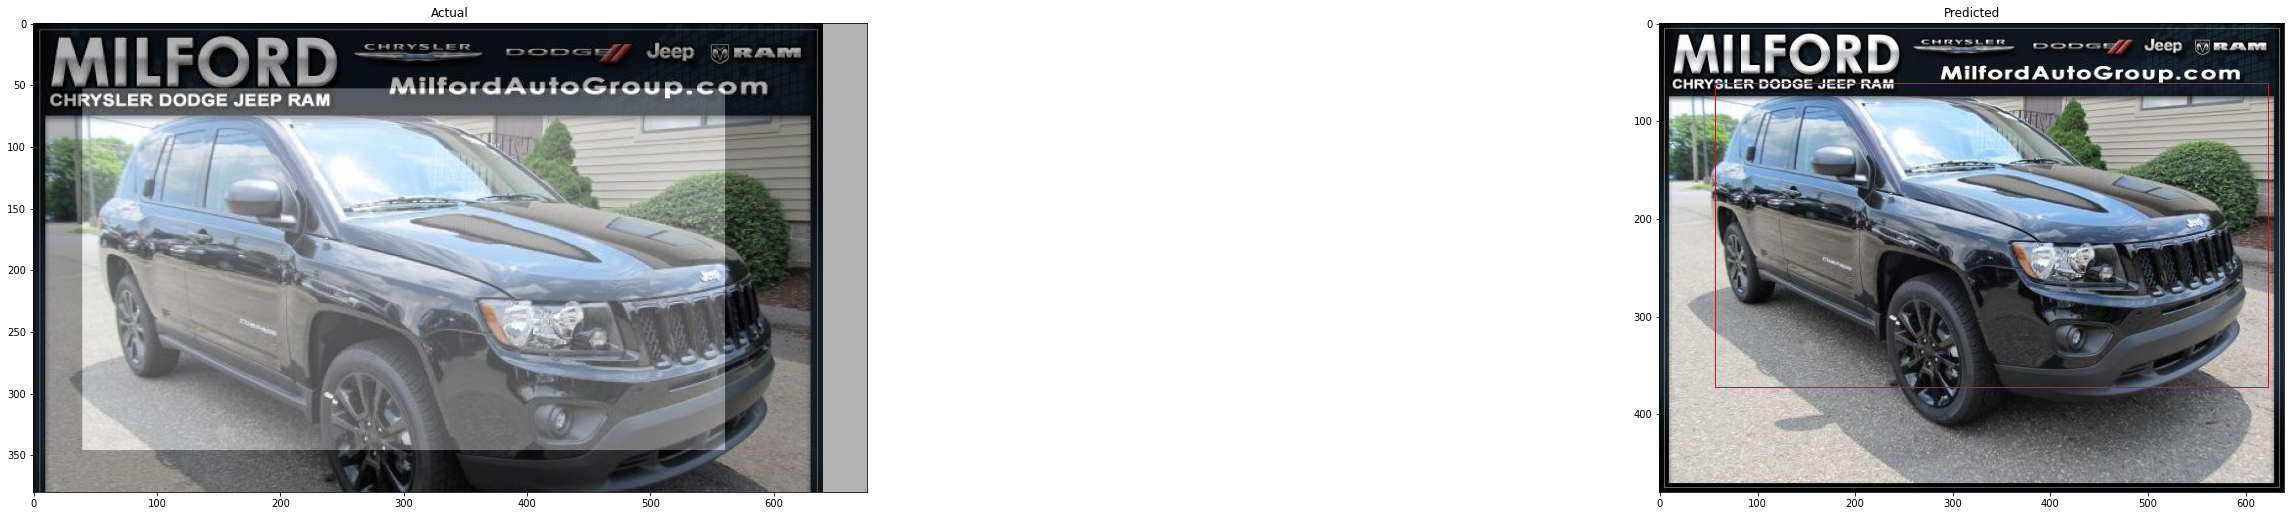

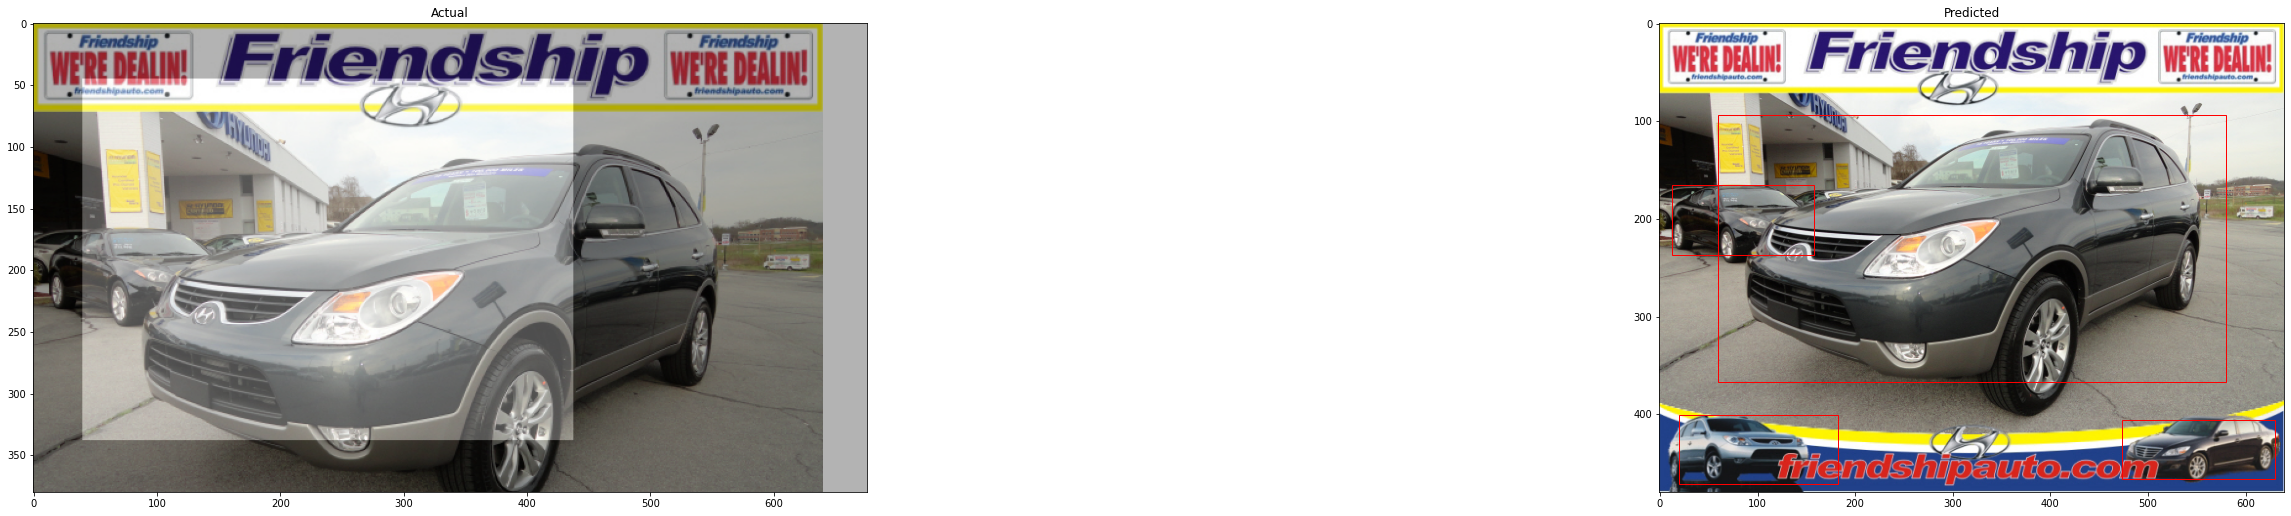

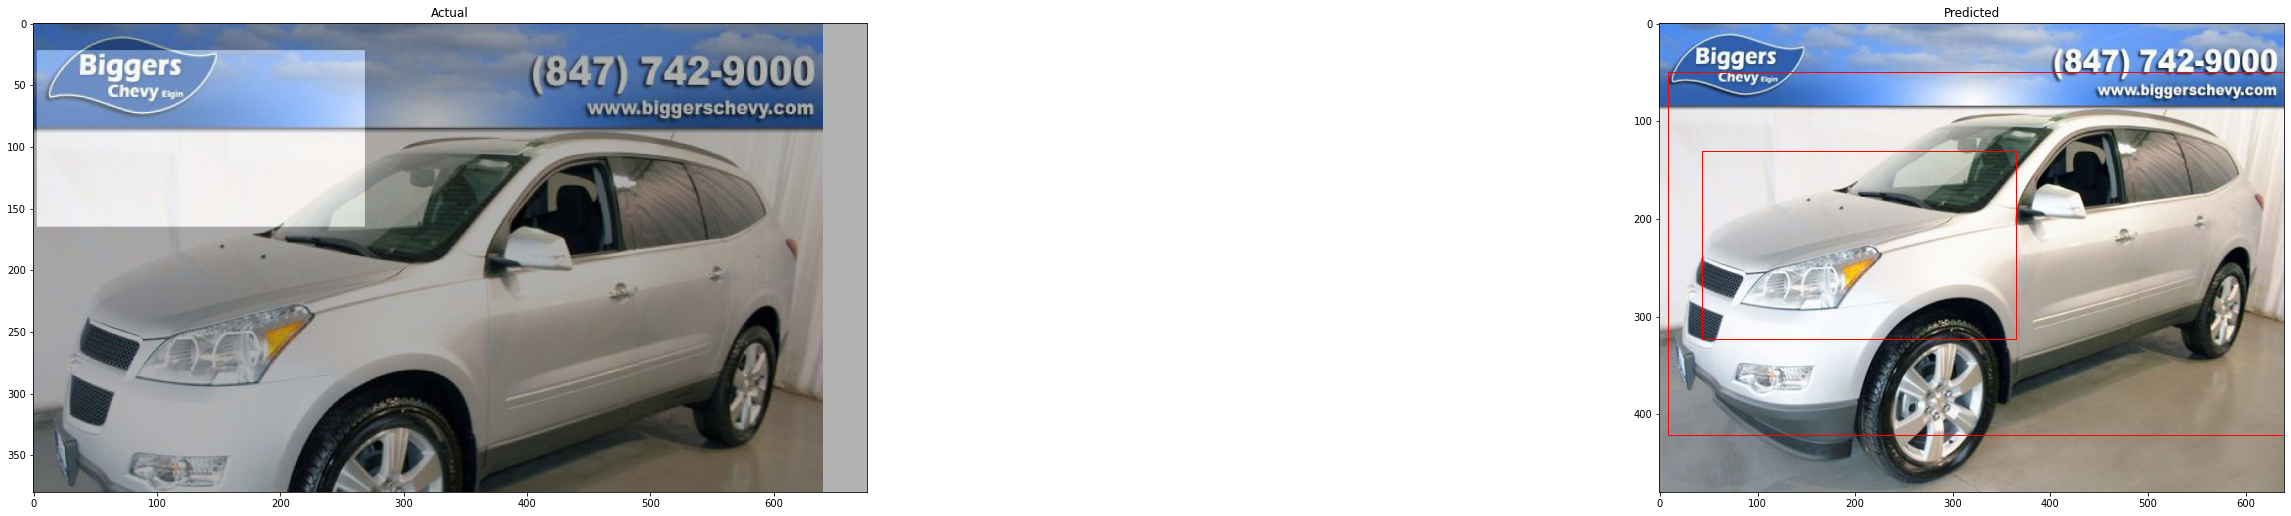

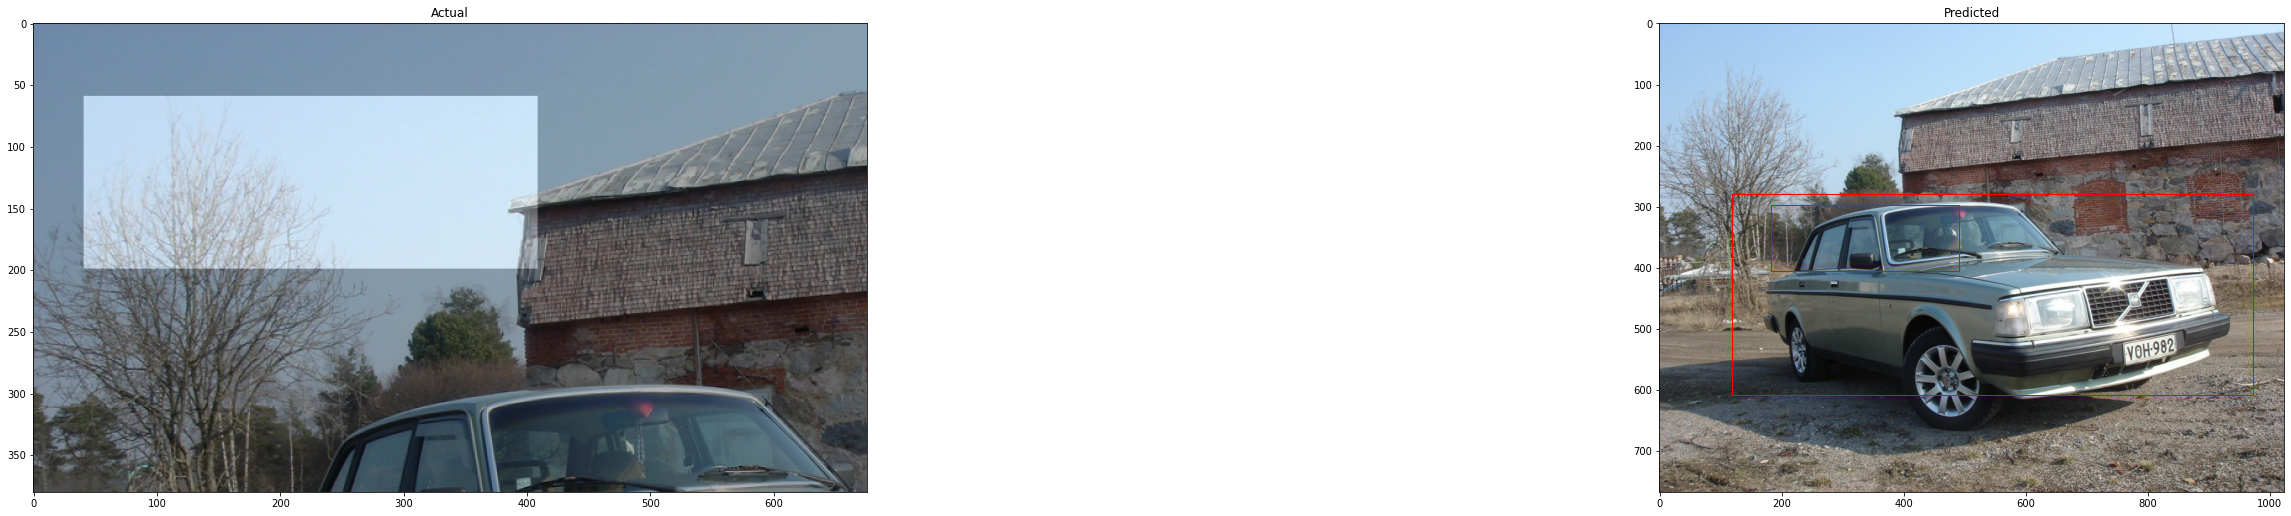

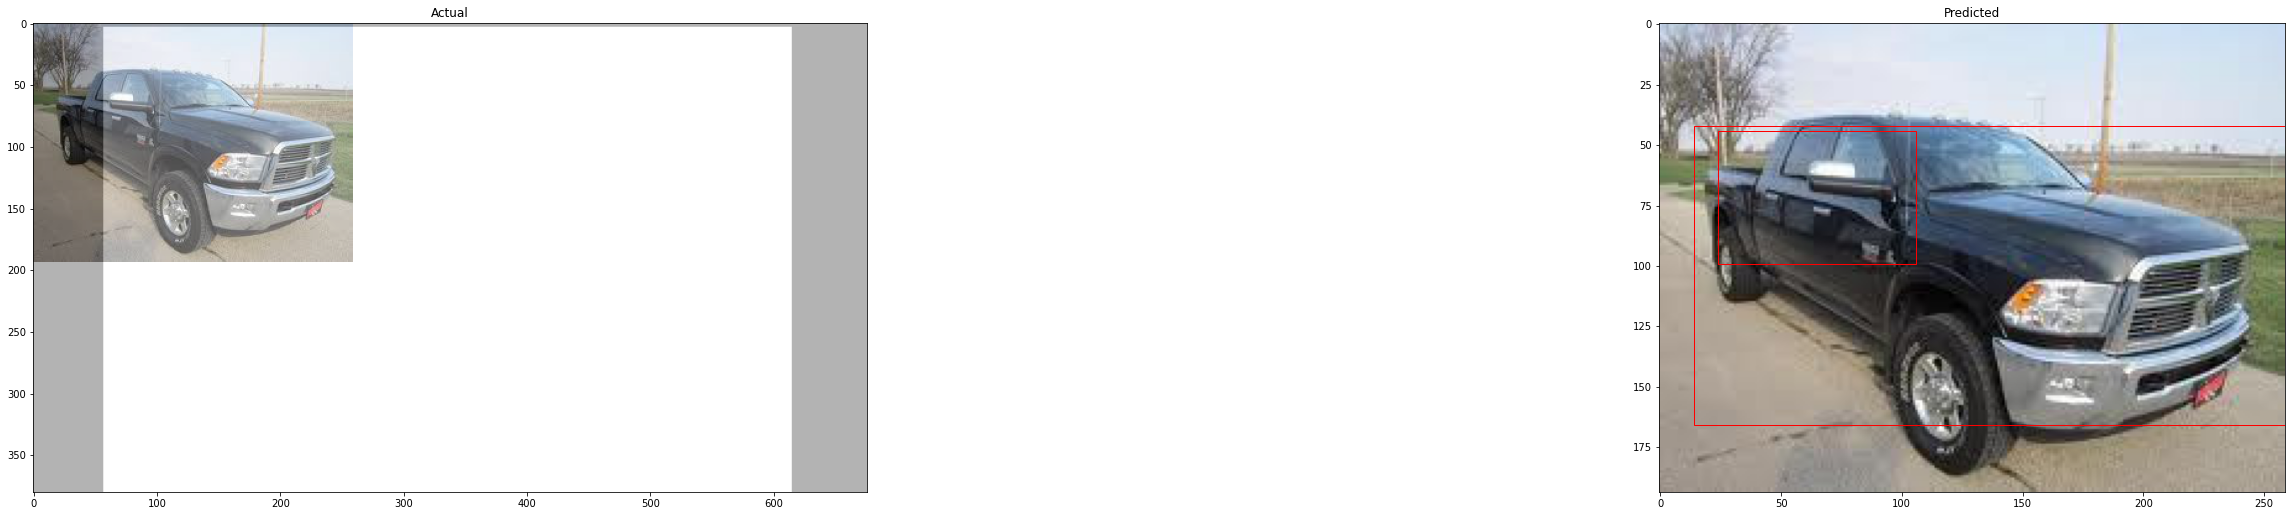

In [43]:
#showing actual vs predicted for test_set
from matplotlib.patches import Rectangle
plot_actual_vs_predicted(test_set, model, cfg)


In [44]:

import matplotlib.pyplot as plt
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax



## **Predicting the mask and bounding box for a random image from test set**

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


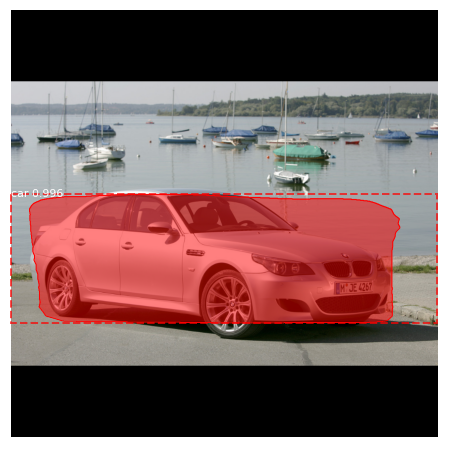

In [45]:
import random
from mrcnn import visualize
image_id = random.choice(test_set.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(test_set, cfg, image_id)
#visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, train_set.class_names, figsize=(8, 8))
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'],test_set.class_names, r['scores'], ax=get_ax())

## Object detection and Mask is identified pretty good with this model.
## MAP needs to be calculated to find out how good the model is behaving.